# Klasteryzacja

In [135]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.cm as cm

In [88]:
clean_data = pd.read_csv("clean_data.csv", encoding="latin1")

clean_data = clean_data.rename(columns={
    "ï»¿Kraj": "Kraj"
})

clean_data['Gini'] = clean_data['Gini']/100

In [90]:
vars_cluster = [
    'Gini',
    'PKB_pc',
    'Edukacja',
    'Dlugosc_zycia',
    'Wspolczynnik_urbanizacji',
    'Dzieci_0-14'
]

# agregacja zmiennych liczbowych
df_num = (
    clean_data
    .groupby('Kraj')[vars_cluster]
    .mean()
    .dropna()
)

# dociągnięcie kontynentu
df_continent = (
    clean_data[['Kraj', 'Kontynent']]
    .drop_duplicates()
    .set_index('Kraj')
)

df_cluster = df_num.join(df_continent)

# standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[vars_cluster])


In [91]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# wariancja wyjaśniona
explained_var = pd.Series(
    pca.explained_variance_ratio_,
    index=[f'PC{i+1}' for i in range(len(vars_cluster))]
)

print("Wariancja wyjaśniona:")
print(explained_var)
print("Suma PC1+PC2:", explained_var.iloc[:2].sum())


Wariancja wyjaśniona:
PC1    0.578894
PC2    0.157451
PC3    0.140061
PC4    0.056278
PC5    0.047039
PC6    0.020278
dtype: float64
Suma PC1+PC2: 0.7363443366991806


In [92]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=vars_cluster,
    columns=[f'PC{i+1}' for i in range(len(vars_cluster))]
)

print(loadings)


                               PC1       PC2       PC3       PC4       PC5  \
Gini                     -0.295658  0.339606  0.804368 -0.208097 -0.316355   
PKB_pc                    0.460965 -0.029664  0.149994  0.692352 -0.533511   
Edukacja                  0.163812  0.927609 -0.334057  0.002669  0.000265   
Dlugosc_zycia             0.494602 -0.033491  0.075713 -0.472530 -0.178756   
Wspolczynnik_urbanizacji  0.430761  0.088100  0.460990  0.191470  0.746058   
Dzieci_0-14              -0.493029  0.120191  0.025608  0.466253  0.163491   

                               PC6  
Gini                     -0.082833  
PKB_pc                   -0.012181  
Edukacja                 -0.033252  
Dlugosc_zycia             0.702336  
Wspolczynnik_urbanizacji -0.030141  
Dzieci_0-14               0.705478  


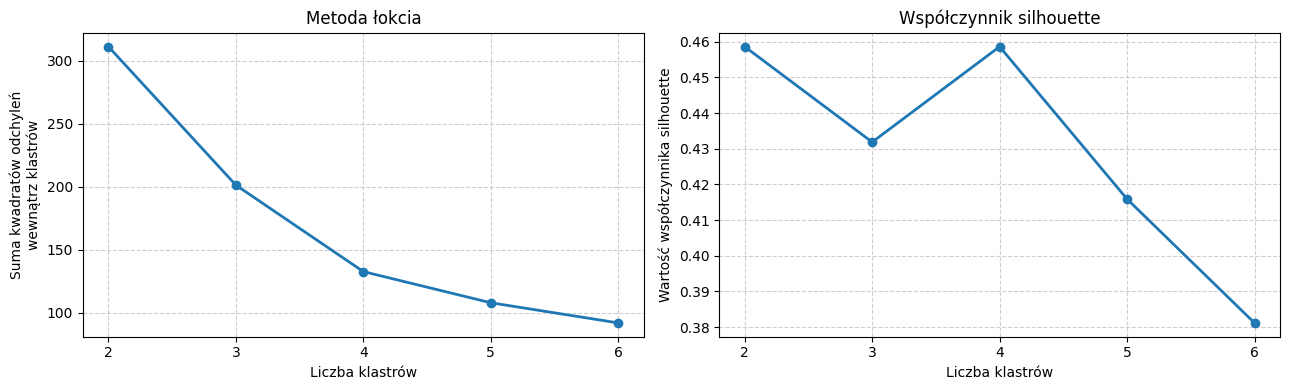

In [154]:
inertia = []
silhouette = []

K = range(2, 7)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_pca[:, :2])
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X_pca[:, :2], labels))


fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(K, inertia, marker='o', linewidth=2)
ax[0].set_title('Metoda łokcia')
ax[0].set_xlabel('Liczba klastrów')
ax[0].set_ylabel('Suma kwadratów odchyleń\nwewnątrz klastrów')
ax[0].set_xticks(K)
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].plot(K, silhouette, marker='o', linewidth=2)
ax[1].set_title('Współczynnik silhouette')
ax[1].set_xlabel('Liczba klastrów')
ax[1].set_ylabel('Wartość współczynnika silhouette')
ax[1].set_xticks(K)
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [98]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_pca[:, :2])

df_cluster['Cluster'] = clusters


In [99]:
cluster_summary = (
    df_cluster
    .groupby('Cluster')[vars_cluster]
    .mean()
    .round(2)
)

print(cluster_summary)

         Gini    PKB_pc  Edukacja  Dlugosc_zycia  Wspolczynnik_urbanizacji  \
Cluster                                                                      
0        0.41   5324.79      2.95          58.77                     33.93   
1        0.32  45819.69      5.08          78.24                     75.80   
2        0.46  10381.49      7.82          63.56                     49.74   
3        0.40  17007.96      3.94          72.10                     58.04   

         Dzieci_0-14  
Cluster               
0              42.74  
1              17.23  
2              37.14  
3              27.95  


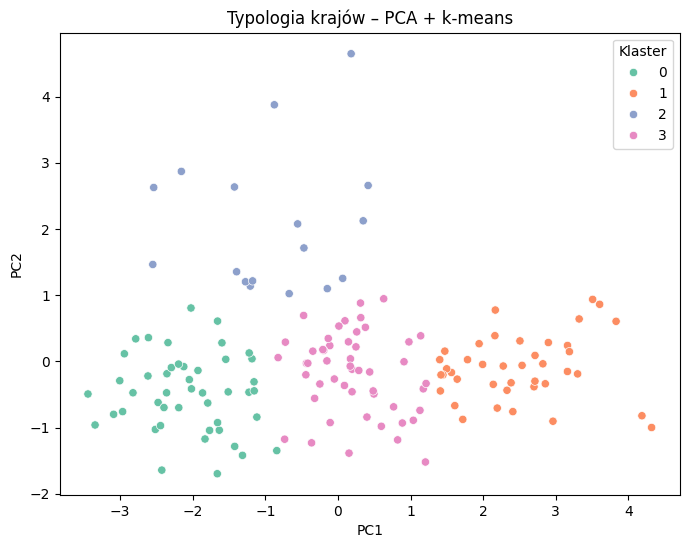

In [100]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_cluster['Cluster'],
    palette='Set2'
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Typologia krajów – PCA + k-means')
plt.legend(title='Klaster')
plt.show()


In [101]:
cluster_continent = (
    df_cluster
    .groupby(['Kontynent', 'Cluster'])
    .size()
    .unstack(fill_value=0)
)

print(cluster_continent)


Cluster         0   1  2   3
Kontynent                   
Africa         34   0  8   7
Asia            8   5  2  18
Europe          0  31  0   6
North America   2   2  2   9
Oceania         2   1  3   2
South America   0   1  2   8


In [108]:
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(url)

In [117]:
cluster_map = pd.DataFrame({
    "Kraj": df_cluster.index,
    "Cluster": df_cluster["Cluster"]
}).reset_index(drop=True)

country_map = {
    "Bahamas": "The Bahamas",
    "Cote dâ\x80\x99Ivoire": "Ivory Coast",
    "Czech Republic": "Czechia",
    "Brunei Darussalam": "Brunei",
    "DR Congo": "Democratic Republic of the Congo",
    "Timor-Leste": "East Timor",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Serbia": "Republic of Serbia",
    "Korea": "South Korea",
    "Congo": "Republic of the Congo",
    "Syrian Arab Republic": "Syria",
    "Tanzania": "United Republic of Tanzania",
    "Viet Nam": "Vietnam",
    "USA": "United States of America",
    "Eswatini": "eSwatini",
    "Russian Federation": "Russia"

}
cluster_map["Kraj"] = cluster_map["Kraj"].replace(country_map)

In [118]:
world_cluster = world.merge(
    cluster_map,
    left_on="SOVEREIGNT",
    right_on="Kraj",
    how="left"
)

C:\Users\hnowa\AppData\Local\Temp\ipykernel_31820\1736824803.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 4)


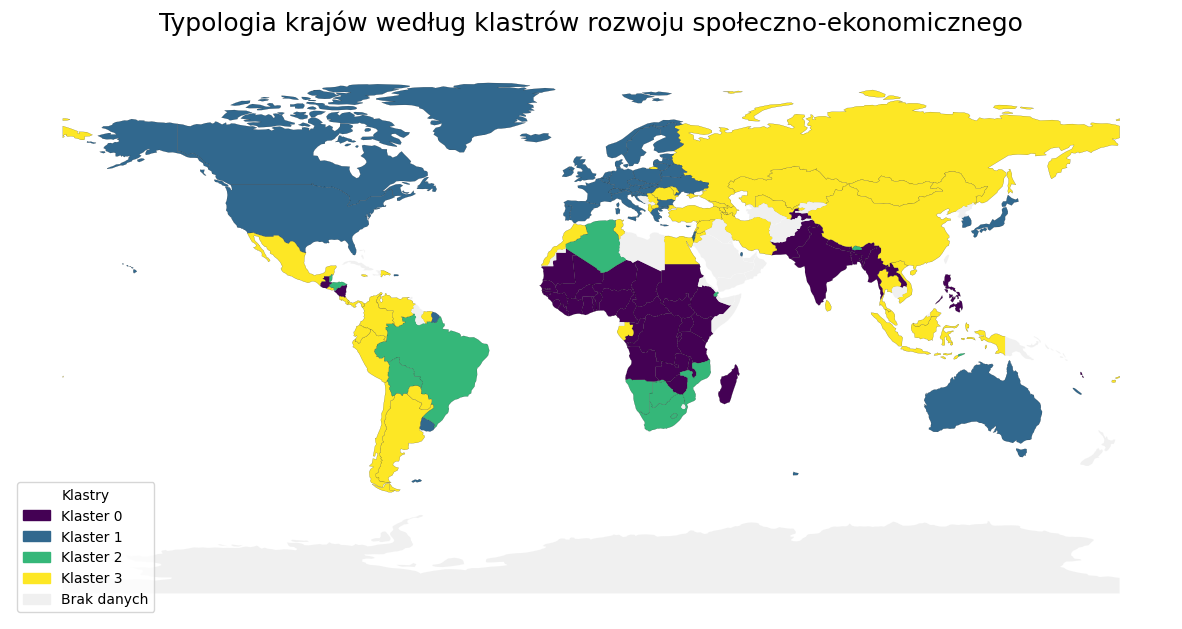

In [143]:
fig, ax = plt.subplots(figsize=(15, 9))

# paleta jakościowa
cmap = cm.get_cmap("viridis", 4)

world_cluster.plot(
    column="Cluster",
    cmap=cmap,
    linewidth=0.1,
    edgecolor="black",
    ax=ax,
    legend=False,
    missing_kwds={
        "color": "#f0f0f0",
        "edgecolor": "white",
        "label": "Brak danych"
    }
)

ax.set_title(
    "Typologia krajów według klastrów rozwoju społeczno-ekonomicznego",
    fontsize=18,
    pad=20
)

ax.axis("off")

# ręczna legenda
legend_elements = [
    mpatches.Patch(color=cmap(i), label=f"Klaster {i}")
    for i in range(4)
]
legend_elements.append(
    mpatches.Patch(color="#f0f0f0", label="Brak danych")
)

ax.legend(
    handles=legend_elements,
    title="Klastry",
    loc="lower left",
    frameon=True
)

plt.show()
